In [1]:
import os
HOME = os.getcwd()
print("HOME", HOME)

HOME /content


In [2]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'


/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-kqvye0pp
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-kqvye0pp
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36588 sha256=ec37eb3d98d10a9dd1f1978c094ee6ce171d699314b9a668f1027542c25418e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-02o0iv46/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [3]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.1 MB/s eta 0:00:00


In [4]:
%cd {HOME}

!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [5]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; EXISTS : ", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; EXISTS :  True


In [6]:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

/content
/content/data


In [7]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [8]:
!pip install segment_anything

In [9]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [ ]:
mask_predictor = SamPredictor(sam)

In [ ]:
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Union, Optional
from dataclasses_json import dataclass_json
from supervision import Detections


@dataclass_json
@dataclass
class COCOCategory:
    id: int
    name: str
    supercategory: str

@dataclass_json
@dataclass
class COCOImage:
    id: int
    width: int
    height: int
    file_name: str
    license: int
    date_captured: str
    coco_url: Optional[str] = None
    flickr_url: Optional[str] = None


@dataclass_json
@dataclass
class COCOAnnotation:
    id: int
    image_id: int
    category_id: int
    segmentation: List[List[float]]
    area: float
    bbox: Tuple[float, float, float, float]
    iscrowd: int


@dataclass_json
@dataclass
class COCOLicense:
    id: int
    name: str
    url: str


@dataclass_json
@dataclass
class COCOJson:
    images: List[COCOImage]
    annotations: List[COCOAnnotation]
    categories: List[COCOCategory]
    licenses: List[COCOLicense]


def load_coco_json(json_file: str) -> COCOJson:
    import json

    with open(json_file, "r") as f:
        json_data = json.load(f)

    return COCOJson.from_dict(json_data)


class COCOJsonUtility:
    @staticmethod
    def get_annotations_by_image_id(coco_data: COCOJson, image_id: int) -> List[COCOAnnotation]:
        return [annotation for annotation in coco_data.annotations if annotation.image_id == image_id]

    @staticmethod
    def get_annotations_by_image_path(coco_data: COCOJson, image_path: str) -> Optional[List[COCOAnnotation]]:
        image = COCOJsonUtility.get_image_by_path(coco_data, image_path)
        if image:
            return COCOJsonUtility.get_annotations_by_image_id(coco_data, image.id)
        else:
            return None

    @staticmethod
    def get_image_by_path(coco_data: COCOJson, image_path: str) -> Optional[COCOImage]:
        for image in coco_data.images:
            if image.file_name == image_path:
                return image
        return None

    @staticmethod
    def annotations2detections(annotations: List[COCOAnnotation]) -> Detections:
        class_id, xyxy = [], []

        for annotation in annotations:
            x_min, y_min, width, height = annotation.bbox
            class_id.append(annotation.category_id)
            print(class_id)
            xyxy.append([
                x_min,
                y_min,
                x_min + width,
                y_min + height
            ])
            print(class_id)

        return Detections(
            xyxy=np.array(xyxy, dtype=int),
            class_id=np.array([1], dtype=int)
        )

In [ ]:
%cd {HOME}

import roboflow
from roboflow import Roboflow

roboflow.login()

rf = Roboflow()

project = rf.workspace("hashira-fhxpj").project("mri-brain-tumor")
dataset = project.version(1).download("coco")

/content
visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to MRI-BRAIN-TUMOR-1 in coco:: 100%|██████████| 85/85 [00:00<00:00, 6746.57it/s]


In [ ]:
import os

DATA_SET_SUBDIRECTORY = "test"
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"
IMAGES_DIRECTORY_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY)
ANNOTATIONS_FILE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, ANNOTATIONS_FILE_NAME)

In [ ]:
coco_data = load_coco_json(json_file=ANNOTATIONS_FILE_PATH)

CLASSES = [
    category.name
    for category
    in coco_data.categories
    if category.supercategory != 'none'
]

IMAGES = [
    image.file_name
    for image
    in coco_data.images
]

[1]
[1]
None
[1]


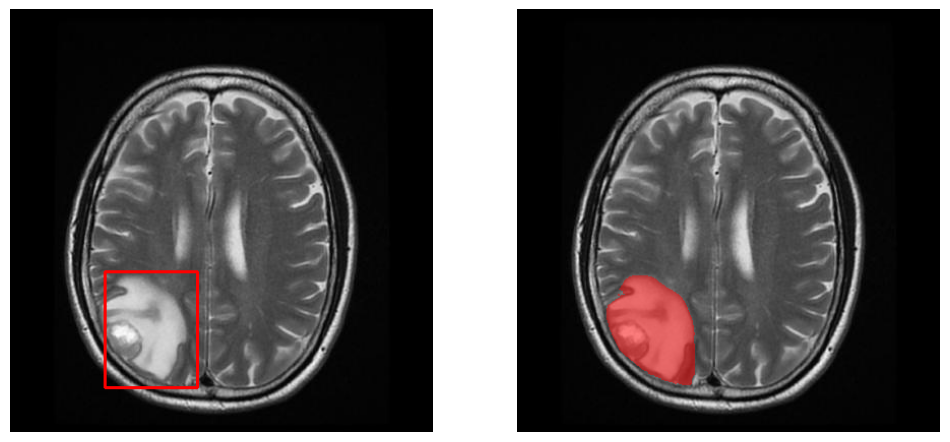

In [ ]:
import cv2
import numpy as np
import supervision as sv

# EXAMPLE_IMAGE_NAME = 'Y15_jpg.rf.ef14d75b886fd9ce299d12ffe480c5e9.jpg'
# EXAMPLE_IMAGE_PATH = '/content/MRI-BRAIN-TUMOR-1/test/Y15_jpg.rf.ef14d75b886fd9ce299d12ffe480c5e9.jpg'

EXAMPLE_IMAGE_NAME = 'Y33_jpg.rf.f3e7bf77085ecd9dd6c9cfbc268b8fc0.jpg'
EXAMPLE_IMAGE_PATH = '/content/MRI-BRAIN-TUMOR-1/test/Y33_jpg.rf.f3e7bf77085ecd9dd6c9cfbc268b8fc0.jpg'

# load dataset annotations
annotations = COCOJsonUtility.get_annotations_by_image_path(coco_data=coco_data, image_path=EXAMPLE_IMAGE_NAME)
ground_truth = COCOJsonUtility.annotations2detections(annotations=annotations)

# small hack - coco numerate classes from 1, model from 0 + we drop first redundant class from coco json
ground_truth.class_id = ground_truth.class_id - 1

# load image
image_bgr = cv2.imread(EXAMPLE_IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# initiate annotator
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

# annotate ground truth
annotated_frame_ground_truth = box_annotator.annotate(scene=image_bgr.copy(), detections=ground_truth, skip_label=True)

# run SAM inference
mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=ground_truth.xyxy[0],
    multimask_output=True
)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

print(detections.class_id)
detections.class_id = [1]
print(detections.class_id)
annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)


sv.plot_images_grid(
    images=[annotated_frame_ground_truth, annotated_image],
    grid_size=(1, 2),
    titles=['', '']
)


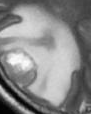

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
image = image_rgb

#cv2_imshow(image)
y=ground_truth.xyxy[0][0]
x=ground_truth.xyxy[0][1]
h=ground_truth.xyxy[0][2]
w=ground_truth.xyxy[0][3]
crop_image = image[x:w, y:h]
cv2_imshow(crop_image)

[1]
[1]


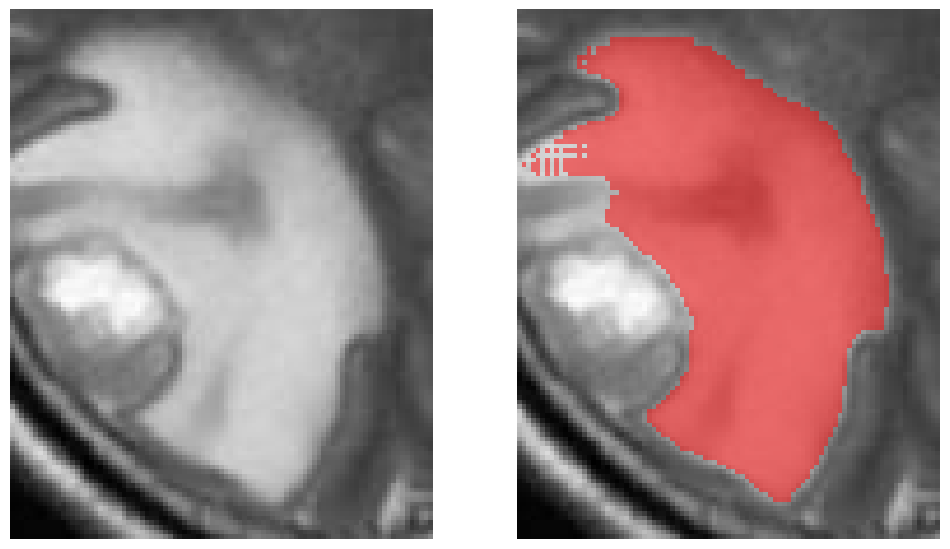

In [ ]:
import cv2
import numpy as np
import supervision as sv

EXAMPLE_IMAGE_NAME = 'Y33_jpg.rf.f3e7bf77085ecd9dd6c9cfbc268b8fc0.jpg'
EXAMPLE_IMAGE_PATH = '/content/MRI-BRAIN-TUMOR-1/test/Y33_jpg.rf.f3e7bf77085ecd9dd6c9cfbc268b8fc0.jpg'

annotations = COCOJsonUtility.get_annotations_by_image_path(coco_data=coco_data, image_path=EXAMPLE_IMAGE_NAME)
ground_truth = COCOJsonUtility.annotations2detections(annotations=annotations)

ground_truth.class_id = ground_truth.class_id - 1

image_rgb = cv2.cvtColor(crop_image, cv2.COLOR_BGR2RGB)

box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

annotated_frame_ground_truth = box_annotator.annotate(scene=crop_image.copy(), detections=ground_truth, skip_label=True)


mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=ground_truth.xyxy[0],
    multimask_output=True
)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)

detections = detections[detections.area == np.max(detections.area)]
detections.class_id = [1]
annotated_image = mask_annotator.annotate(scene=image_rgb.copy(), detections=detections)

sv.plot_images_grid(
    images=[annotated_frame_ground_truth, annotated_image],
    grid_size=(1, 2),
    titles=['', '']
)

In [ ]:
def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3)

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

In [ ]:
dice_score = dice_coef(annotated_frame_ground_truth, annotated_image)
print(dice_score)

dice_score = iou(annotated_frame_ground_truth, annotated_image)
print(dice_score)

0.913
0.839


In [ ]:
from skimage import img_as_float
from skimage.metrics import peak_signal_noise_ratio
from matplotlib import pyplot as plt
from skimage import io
from scipy import ndimage as nd
from google.colab.patches import cv2_imshow

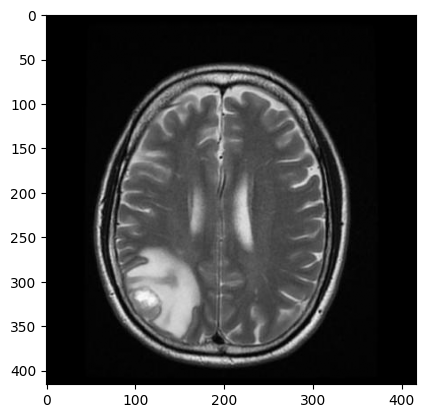

In [ ]:
noisy_img = img_as_float(io.imread("/content/MRI-BRAIN-TUMOR-1/test/Y33_jpg.rf.f3e7bf77085ecd9dd6c9cfbc268b8fc0.jpg"))
plt.imshow(noisy_img, cmap='gray')

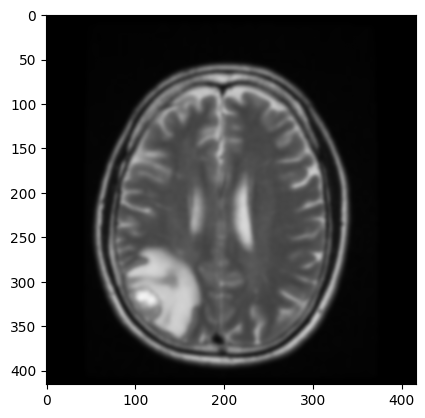

In [ ]:
gaussian_img = nd.gaussian_filter(noisy_img, sigma=2)
plt.imshow(gaussian_img, cmap='gray')

In [ ]:
%cd {HOME}

!mkdir {HOME}/output

/content


In [ ]:
plt.imsave("/content/output/gauss.jpeg", gaussian_img, cmap='gray')

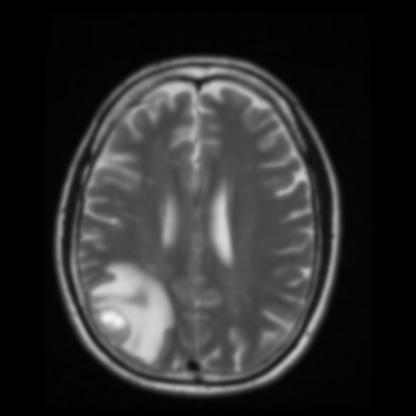

In [ ]:
img = cv2.imread('/content/output/gauss.jpeg')
cv2_imshow(img)

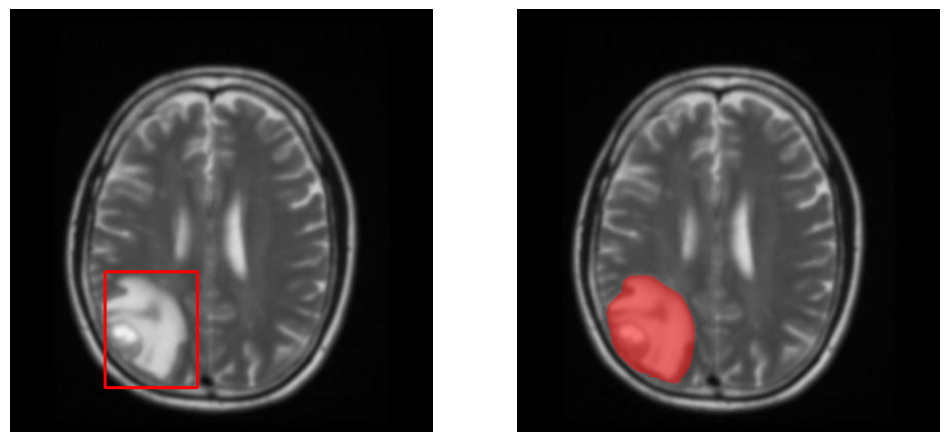

In [ ]:
import cv2
import numpy as np
import supervision as sv

img = cv2.imread('/content/output/gauss.jpeg')

image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

annotated_frame_ground_truth = box_annotator.annotate(scene=img.copy(), detections=ground_truth, skip_label=True)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=ground_truth.xyxy[0],
    multimask_output=True
)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)

detections = detections[detections.area == np.max(detections.area)]
detections.class_id = [1]
annotated_image = mask_annotator.annotate(scene=image_rgb.copy(), detections=detections)


sv.plot_images_grid(
    images=[annotated_frame_ground_truth, annotated_image],
    grid_size=(1, 2),
    titles=['', '']
)


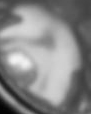

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
image = image_rgb

#cv2_imshow(image)
y=ground_truth.xyxy[0][0]
x=ground_truth.xyxy[0][1]
h=ground_truth.xyxy[0][2]
w=ground_truth.xyxy[0][3]
crop_image = image[x:w, y:h]
cv2_imshow(crop_image)

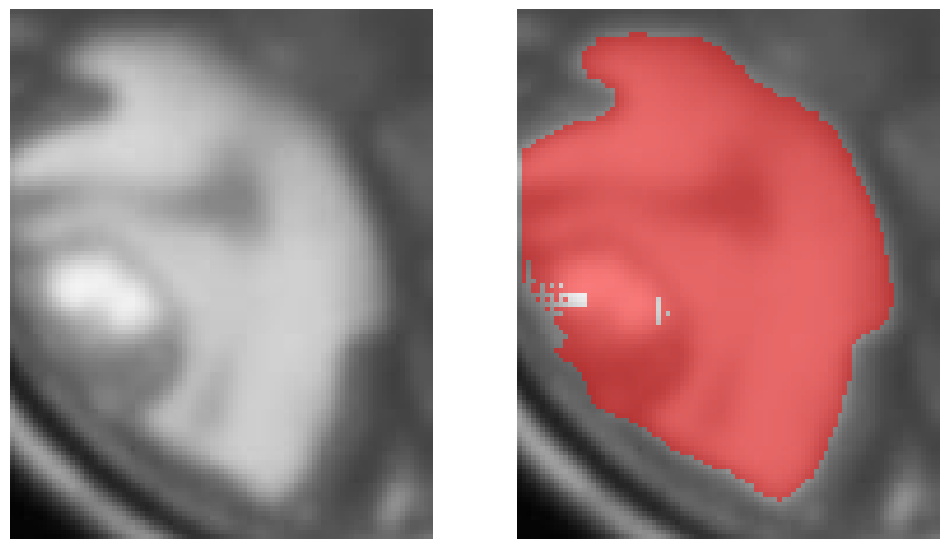

In [ ]:
import cv2
import numpy as np
import supervision as sv

img = cv2.imread('/content/output/gauss.jpeg')

image_rgb = cv2.cvtColor(crop_image, cv2.COLOR_BGR2RGB)

box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

annotated_frame_ground_truth = box_annotator.annotate(scene=crop_image.copy(), detections=ground_truth, skip_label=True)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=ground_truth.xyxy[0],
    multimask_output=True
)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)

detections = detections[detections.area == np.max(detections.area)]
detections.class_id =[1]
annotated_image = mask_annotator.annotate(scene=image_rgb.copy(), detections=detections)

sv.plot_images_grid(
    images=[annotated_frame_ground_truth, annotated_image],
    grid_size=(1, 2),
    titles=['', '']
)

In [ ]:

dice_score = dice_coef(annotated_frame_ground_truth, annotated_image)
print(dice_score)

dice_score = iou(annotated_frame_ground_truth, annotated_image)
print(dice_score)


0.975
0.952
